In [1]:
from speedymf import *
import math, pickle
import matplotlib.pyplot as plt 

# Plot parameters 
plt.rcParams.update({
    "font.family": "georgia",
    'text.latex.preamble': r'\\usepackage{amsmath}',
    'mathtext.fontset': 'cm',
})

# Making some testing data 
test_temp = 850
Xtest = np.linspace(0.6, 1.4, 250).reshape(-1,1)
Xtest = np.hstack(
    (Xtest, np.ones((Xtest.shape[0], 1))*test_temp)
)

# Levels of fidelity
K = 5 

# Temperature vector 
temps = [450, 550, 650, 750, 850]

# Initializing data dict
data_dict = {} 
for level in range(K):
    data_dict[level] = {
        'X':jnp.array([[]]), 
        'Y':jnp.array([[]])
    }


for temp in temps:
    # Loading the data
    with open("data/FlameSpeedData%d.pkl" % temp, 'rb') as infile:
        temp_dict = pickle.load(infile)

    

    for level in temp_dict.keys():
        N = temp_dict[level]['X'].shape[0]

        X, Y = temp_dict[level]['X'], temp_dict[level]['Y']

        Y[Y > 100] *= 1/700

        data_dict[level]['X'] = jnp.vstack(
            (data_dict[level]['X'].reshape(-1,2), X)
        )

        data_dict[level]['Y'] = jnp.vstack(
            (data_dict[level]['Y'].reshape(-1,1), jnp.log(Y).reshape(-1,1))
        )

# Filtering out the high-fidelity data 
test_inds = (data_dict[4]['X'][:,1] == test_temp )
Xtrue, Ytrue = data_dict[4]['X'][test_inds,:], data_dict[4]['Y'][test_inds]
inds = (data_dict[4]['X'][:,1] <600)
data_dict[4]['X'], data_dict[4]['Y'] = data_dict[4]['X'][inds,:], data_dict[4]['Y'][inds]

from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler() 
data_dict[0]['X'] = scaler.fit_transform(data_dict[0]['X'])

for i in range(1,K):
    data_dict[i]['X'] = scaler.transform(data_dict[i]['X'])

Xtest = scaler.transform(Xtest)

# Initializing noise vars
for level in data_dict.keys():
    #data_dict[level]['Y'] *= 0.01 # Converting to m/s
    data_dict[level]['noise_var'] = 1e-5
    #data_dict[level]['mean'] = np.mean(data_dict[level]['Y'])
    #data_dict[level]['Y'] -= data_dict[level]['mean']

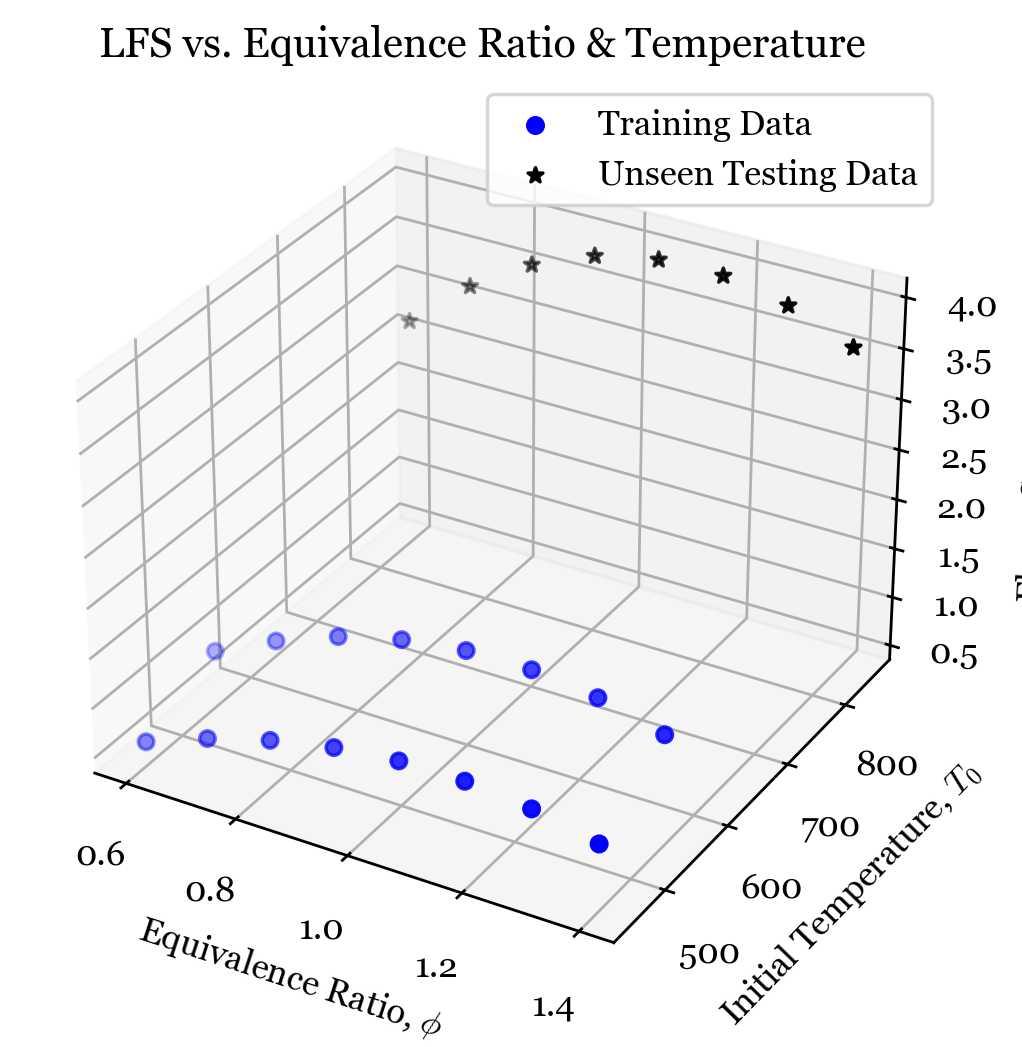

In [2]:
# Set up 3D scatterplot
fig = plt.figure(dpi=250)
ax = fig.add_subplot(111, projection='3d')
# Plot
level = 4
ax.scatter(scaler.inverse_transform(data_dict[level]['X'])[:,0], scaler.inverse_transform(data_dict[level]['X'])[:,1], jnp.exp(data_dict[level]['Y']).ravel(), c='blue', marker='o', label = 'Training Data')
ax.scatter(Xtrue[:,0],Xtrue[:,1], jnp.exp(Ytrue).ravel(), marker = '*', c = 'black', label = "Unseen Testing Data")

# Axis labels
ax.set_xlabel('Equivalence Ratio, $\phi$')
ax.set_ylabel('Initial Temperature, $T_0$')
ax.set_zlabel('Flame Speed (m/s)')
ax.legend()

plt.title('LFS vs. Equivalence Ratio & Temperature ')
plt.savefig('HFData.png')

In [161]:
nargp_model = NARGP(
    data_dict, nargp_rbf, jitter = 1e-4
)

In [162]:
nargp_model.optimize(
    0, lr = 1e-5, epochs = 250, beta1=0.9, beta2=0.999, batch_size = 250, shuffle = True 
)

100%|██████████| 250/250 [00:11<00:00, 21.27it/s, Loss: 360.49328, LR: 1.00e-05] 


In [163]:
nargp_model.optimize(
    1, lr = 1e-3, epochs = 250, beta1=0.1, beta2=0.999, batch_size = 250, shuffle = True 
)

100%|██████████| 250/250 [00:15<00:00, 15.96it/s, Loss: -294.87899, LR: 1.00e-03] 


In [164]:
nargp_model.optimize(
    2, lr = 1e-4, epochs = 250, beta1=0.9, beta2=0.999, batch_size = 250, shuffle = True 
)

100%|██████████| 250/250 [00:15<00:00, 15.86it/s, Loss: -796.94940, LR: 1.00e-04]


In [165]:
# nargp_model.d[3]['model'].k_param = np.ones_like(nargp_model.d[3]['model'].k_param)*0.1
nargp_model.optimize(
    3, lr = 1e-4, epochs = 1000, beta1=0.1, beta2=0.999, batch_size = 250, shuffle = True 
)

100%|██████████| 1000/1000 [00:36<00:00, 27.39it/s, Loss: -151.63271, LR: 1.00e-04]


In [193]:
# nargp_model.d[4]['model'].k_param = np.ones_like(nargp_model.d[4]['model'].k_param)*0.1
nargp_model.optimize(
    4, lr = 1e-4, epochs = 1000, beta1=0.3, beta2=0.0, batch_size = 1000, shuffle = True 
)

100%|██████████| 1000/1000 [00:38<00:00, 25.90it/s, Loss: -91.46693, LR: 1.00e-04]


In [3]:
model  = Hyperkriging(
    data_dict, rbf, 3, jitter = 1e-6
)

In [4]:
model.optimize(0, params_to_optimize = ['k_param'], lr = 1e-5, epochs = 250, beta1 = 0.9, beta2 = 0.999, batch_size = 250, shuffle = False)

100%|██████████| 250/250 [00:09<00:00, 26.47it/s, Loss: -1.51257, LR: 1.00e-05]   


In [5]:
model.optimize(1, params_to_optimize = ['k_param'], lr = 1e-4, epochs = 1000, beta1 = 0.9, beta2 = 0.999, batch_size = 250, shuffle = False)

100%|██████████| 1000/1000 [00:24<00:00, 40.89it/s, Loss: -476.02562, LR: 1.00e-04]


In [6]:
model.optimize(2, params_to_optimize = ['k_param'], lr = 1e-3, epochs = 1000, beta1 = 0.9, beta2 = 0.999, batch_size = 250, shuffle = False)

100%|██████████| 1000/1000 [00:11<00:00, 88.75it/s, Loss: -1181.92610, LR: 1.00e-03]


In [7]:
model.optimize(3, params_to_optimize = ['k_param'], lr = 1e-2, epochs = 1000, beta1 = 0.9, beta2 = 0.999, batch_size = 250, shuffle = False)

100%|██████████| 1000/1000 [00:11<00:00, 90.34it/s, Loss: -622.51174, LR: 1.00e-02]


In [9]:
model.optimize(4, params_to_optimize = ['k_param'], lr = 25e-1, epochs = 5000, beta1 = 0.9, beta2 = 0.999, batch_size = 250, shuffle = False)

100%|██████████| 5000/5000 [01:12<00:00, 68.66it/s, Loss: -128.86559, LR: 2.50e+00]


In [10]:
kr_model = LogNormalGP(data_dict[4]['X'], data_dict[4]['Y'], noise_var = data_dict[4]['noise_var'], kernel = rbf, mu = np.zeros(3), cov = np.eye(3)*1e-6)

TypeError: SimpleGP.__init__() missing 1 required positional argument: 'kernel_dim'

In [211]:
kr_model.optimize(
    lr = 1e-1, 
    epochs = 250,
    N_mc = 100
)

100%|██████████| 250/250 [00:06<00:00, 39.00it/s, Loss: -83.86555, LR: 1.00e-01]


In [12]:
mean, cov = model.predict(Xtest, 4) 
conf = 2 * np.sqrt(np.diag(cov))

In [218]:
nargp_mean, nargp_cov = nargp_model.predict(Xtest, 4)
nargp_conf = 2 * np.sqrt(np.diag(nargp_cov))

In [219]:
kr_mean, kr_cov = kr_model.predict(Xtest, N_mc = 1000)
kr_conf = 2 * np.sqrt(np.diag(kr_cov)).ravel()

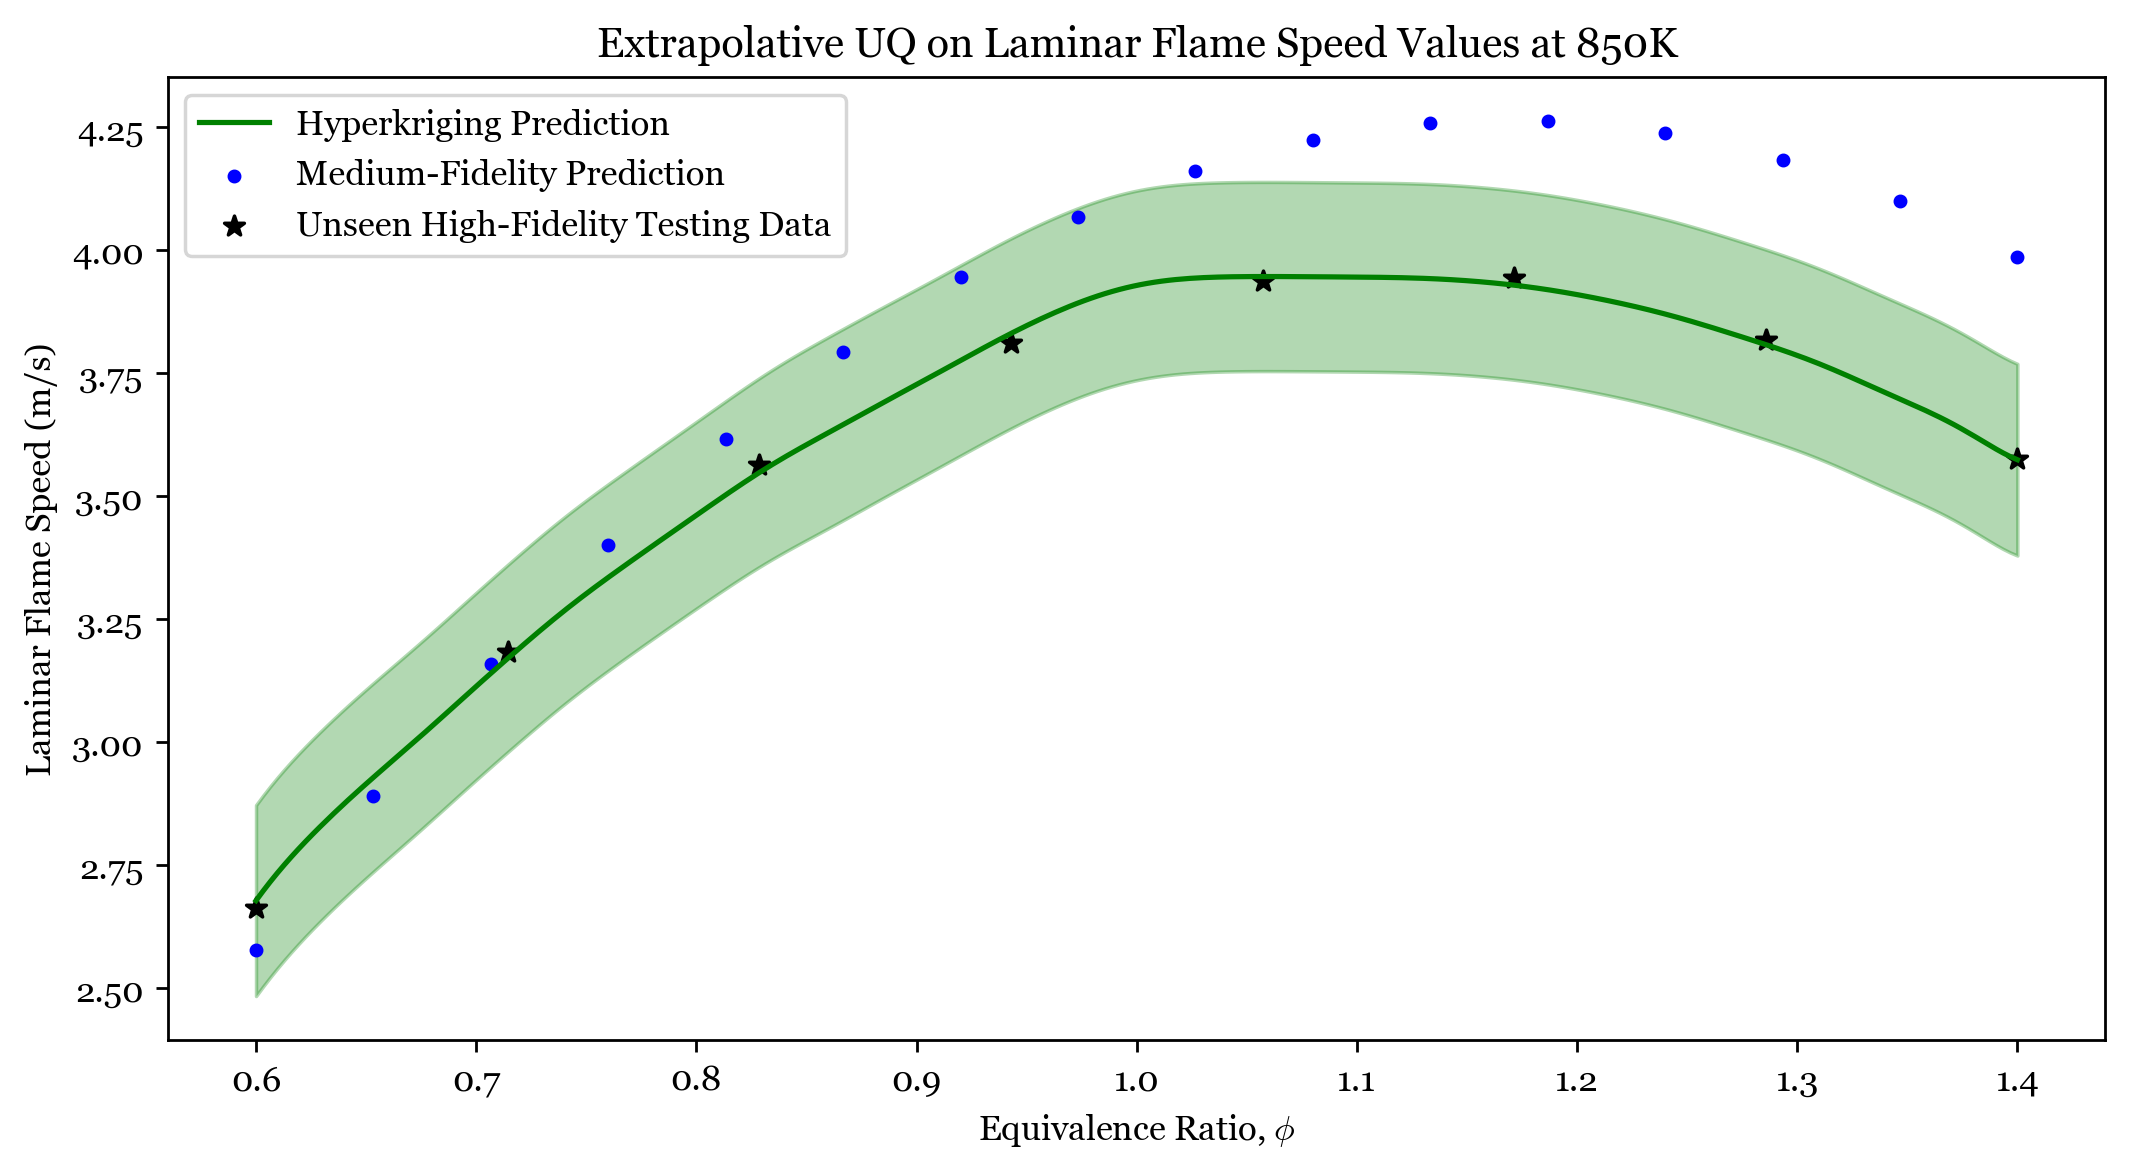

In [13]:
plt.figure(figsize=(10,5),dpi = 250)
#plt.scatter(data_dict[2]['X'], data_dict[2]['Y'] + offset, label = 'High-Fidelity Training Data')
#plt.scatter(phi_true[phi_true > cutoff], V_true[phi_true > cutoff] + offset, marker = '*', color = 'black', label = 'Unseen High-Fidelity Data')
plt.plot(scaler.inverse_transform(Xtest)[:,0], jnp.exp(mean).ravel(), color = 'green', label = 'Hyperkriging Prediction')
plt.fill_between(scaler.inverse_transform(Xtest)[:,0], jnp.exp(mean).ravel()-conf, jnp.exp(mean).ravel() + conf, color = 'green', alpha = 0.3)

# plt.plot(scaler.inverse_transform(Xtest)[:,0], jnp.exp(nargp_mean).ravel(), color = 'purple', label = 'NARGP Prediction')
# plt.fill_between(scaler.inverse_transform(Xtest)[:,0], jnp.exp(nargp_mean).ravel()-nargp_conf, jnp.exp(nargp_mean).ravel() + nargp_conf, color = 'purple', alpha = 0.3)

# plt.plot(scaler.inverse_transform(Xtest)[:,0], np.exp(kr_mean).ravel(), color = 'orange', label = 'Kriging Prediction')
# plt.fill_between(scaler.inverse_transform(Xtest)[:,0], np.exp(kr_mean).ravel() - kr_conf, np.exp(kr_mean).ravel()+kr_conf, alpha = 0.3, color = 'orange')



# plt.plot([cutoff, cutoff], [1.3, 2.7], linestyle = 'dashed', color = 'red', label = 'Design Space')
# plt.plot([0.6, cutoff], [2.7, 2.7], linestyle = 'dashed', color = 'red')
# plt.plot([0.6, cutoff], [1.3, 1.3], linestyle = 'dashed', color = 'red')
# plt.plot([0.6, 0.6], [1.3, 2.7], linestyle = 'dashed', color = 'red')

inds = (scaler.inverse_transform(data_dict[3]['X'])[:,1] == test_temp) 

Xsim, Ysim = data_dict[3]['X'][inds,:], data_dict[3]['Y'][inds]

plt.scatter(scaler.inverse_transform(Xsim)[:,0], jnp.exp(Ysim), marker = '.', color = 'blue', label = 'Medium-Fidelity Prediction')


plt.scatter(Xtrue[:,0], jnp.exp(Ytrue), marker = '*', color = 'black', label = "Unseen High-Fidelity Testing Data")

plt.title("Extrapolative UQ on Laminar Flame Speed Values at %dK" % (test_temp))
plt.xlabel("Equivalence Ratio, $\phi$")
plt.ylabel("Laminar Flame Speed (m/s)")
plt.legend()